
<div align="center">

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dapivei/causal-infere/blob/main/sections/12_RDD.ipynb)

</div>

# Instrumental Variables (Continued) and Intro to Regression Discontinuity (RDD)


## Local Linear Regression for RDD


\begin{align}
Y=\alpha_0+\alpha_1 S+\alpha_2(R-c)+\alpha_3 S *(R-c)
\end{align}

Assumptions:
- The change is linear around the cutoff


\begin{align}
E[Y(S=1, U) - Y(S=0, U) \mid R=c]
\end{align}

- $\alpha_1$: the causal effect of the $R$ around the cutoff
- $\alpha_2 (R-c)$ and $\alpha_3 S *(R-c)$ controls the change respect to $R$.

For a bandwidth $b$, we consider the observations within $R \in (c-b, c+b)$.

## Incumbency Advantage

Election: the situation changes dramatically below 50% and above 50%.

In [1]:
import pandas as pd
data_path = "../data/lee_data.csv"
df = pd.read_csv(data_path)
df

,state,distnum,distid,party,partname,yearel,origvote,totvote,highestvote,sechighestvote,uniqid,officeexp
0,1,1,1,100,D,1946,82231.0,175237.0,93006.0,82231.0,15937,0
1,1,1,1,200,R,1946,93006.0,175237.0,93006.0,82231.0,19281,0
2,1,1,1,100,D,1948,127802.0,233700.0,127802.0,103294.0,23403,0
3,1,1,1,200,R,1948,103294.0,233700.0,127802.0,103294.0,19281,1
4,1,1,1,100,D,1950,134258.0,231096.0,134258.0,96251.0,23403,1
...,...,...,...,...,...,...,...,...,...,...,...,...
19852,93,98,536,100,D,1994,10819.0,31722.0,10819.0,10321.0,21969,0
19853,93,98,536,200,R,1994,5513.0,31722.0,10819.0,10321.0,24134,0
19854,93,98,536,100,D,1996,4162.0,15337.0,7202.0,4162.0,5978,0
19855,93,98,536,200,R,1996,3973.0,15337.0,7202.0,4162.0,17750,0


In [2]:
df["voteshare"] = df["origvote"] / df["totvote"]
df["winner"] = (df["voteshare"] > 0.5).astype(int)
df.head()

,state,distnum,distid,party,partname,yearel,origvote,totvote,highestvote,sechighestvote,uniqid,officeexp,voteshare,winner
0,1,1,1,100,D,1946,82231.0,175237.0,93006.0,82231.0,15937,0,0.469256,0
1,1,1,1,200,R,1946,93006.0,175237.0,93006.0,82231.0,19281,0,0.530744,1
2,1,1,1,100,D,1948,127802.0,233700.0,127802.0,103294.0,23403,0,0.546864,1
3,1,1,1,200,R,1948,103294.0,233700.0,127802.0,103294.0,19281,1,0.441994,0
4,1,1,1,100,D,1950,134258.0,231096.0,134258.0,96251.0,23403,1,0.580962,1


In [3]:
df["winner"].value_counts()

winner
1    10300
0     9557
Name: count, dtype: int64

<Axes: xlabel='voteshare', ylabel='winner'>

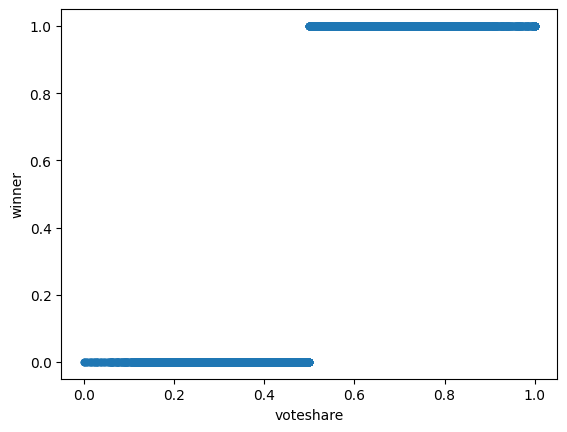

In [4]:
# plot the voteshare and winner
df.plot(x="voteshare", y="winner", kind="scatter")

## Smoothness Test:

\begin{align}
E_U[Y(S=1, U) \mid R=r] \\
E_U[Y(S=0, U) \mid R=r]
\end{align}
are smooth around the cutoff.

We have a multivariate variable $U$, we would like to test if $U$ is smooth around the cutoff, it is hard to test as we do not know the distribution of $U$, but we can **test the components of $U$ separately.**

NOTE: we make strong assumptions, the components of $U$ are smooth does not imply $U$ is smooth, just a weak version of the Smoothness Assumption.

<Axes: ylabel='Frequency'>

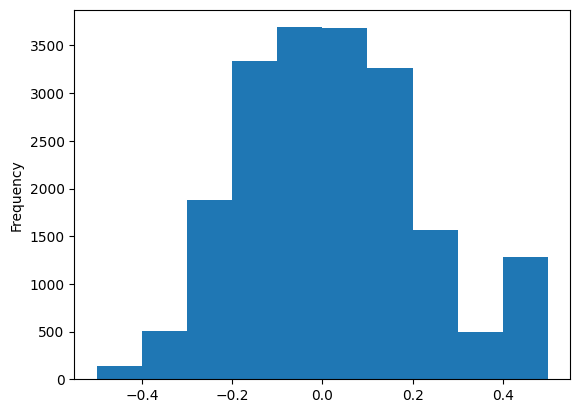

In [5]:
# calcualte the margin of win
df["margin"] = df["voteshare"] - 0.5
df["margin"].plot(kind="hist")

<Axes: ylabel='Frequency'>

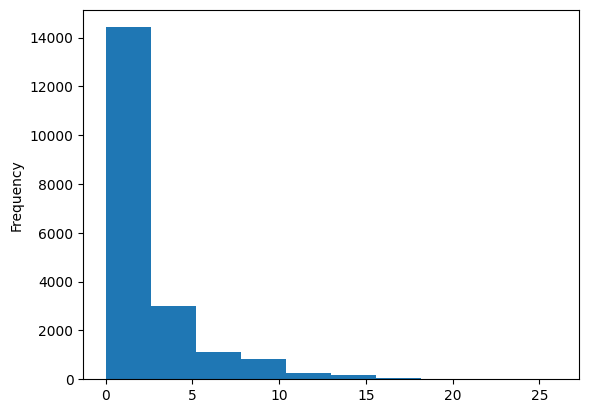

In [6]:
df['officeexp'].plot(kind="hist")

<Axes: xlabel='margin', ylabel='officeexp'>

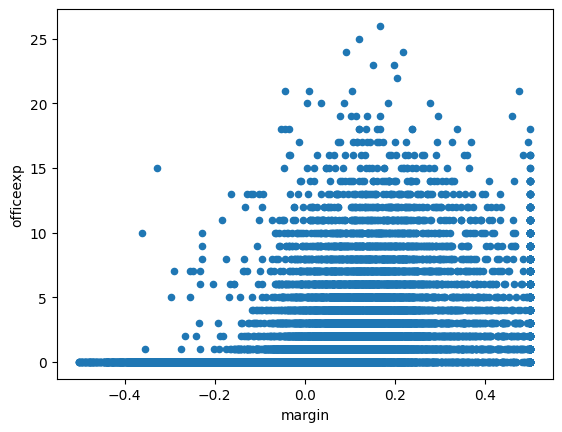

In [7]:
# x axis as margin, y axis as officeexp
df.plot(x="margin", y="officeexp", kind="scatter")

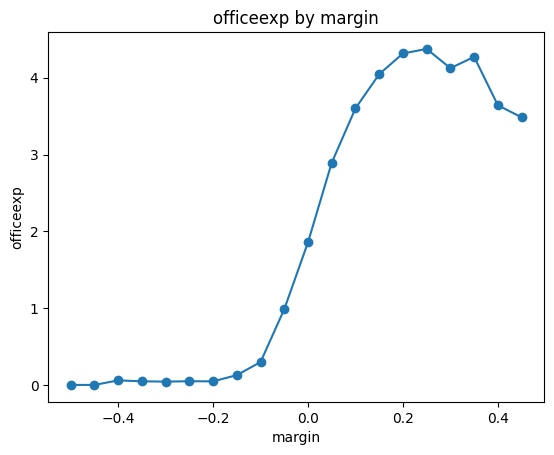

In [8]:
# x axis as margin, y axis as officeexp
# bin size 0.05
import numpy as np
import matplotlib.pyplot as plt
# bin size 0.05
plot_list = []
for i in np.arange(-0.5, 0.5, 0.05):
    df_bin = df[df["margin"].between(i, i+0.05)]
    plot_list.append(df_bin["officeexp"].mean())
plt.plot(np.arange(-0.5, 0.5, 0.05), plot_list, marker="o")
plt.xlabel("margin")
plt.ylabel("officeexp")
plt.title("officeexp by margin")
plt.show()

## Bunching

51 is win, there is no difference between 50 and 51.

Interesting Case: Alpha Go will choose 51 with higher confidence rather than 98 with lower confidence.

This may break the assumption of smoothness, so lots of winners are just bunching at $50 + \epsilon$.

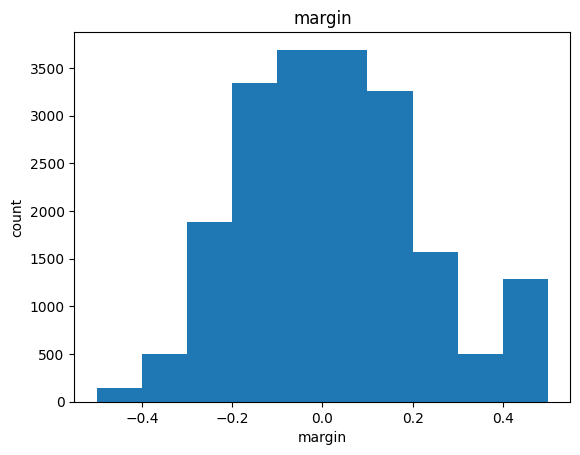

In [9]:
# histgram of margin
df["margin"].plot(kind="hist")
plt.xlabel("margin")
plt.ylabel("count")
plt.title("margin")
plt.show()

Maybe it is hard to control the variance for human, but for Alpha Go, it is easy to control the variance :).

Here is one example of bunching:


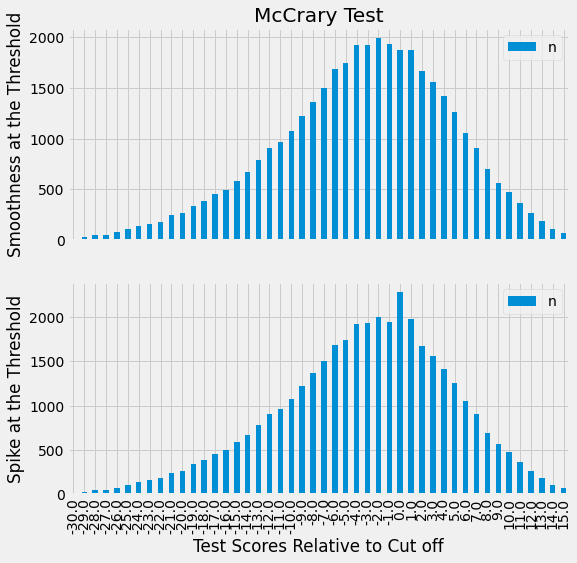

## Is Drinking Killing You?

In [10]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

style.use("fivethirtyeight")

In [11]:
drinking = pd.read_csv("../data/drinking.csv")
drinking.head()[["agecell", "all", "mva", "suicide"]]

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


In [12]:
drinking["agecell"] -= 21

To do so we can grab some mortality data aggregated by age. Each row is the average age of a group of people and the average mortality by all causes (`all`), by moving vehicle accident (`mva`) and by suicide (`suicide`). 

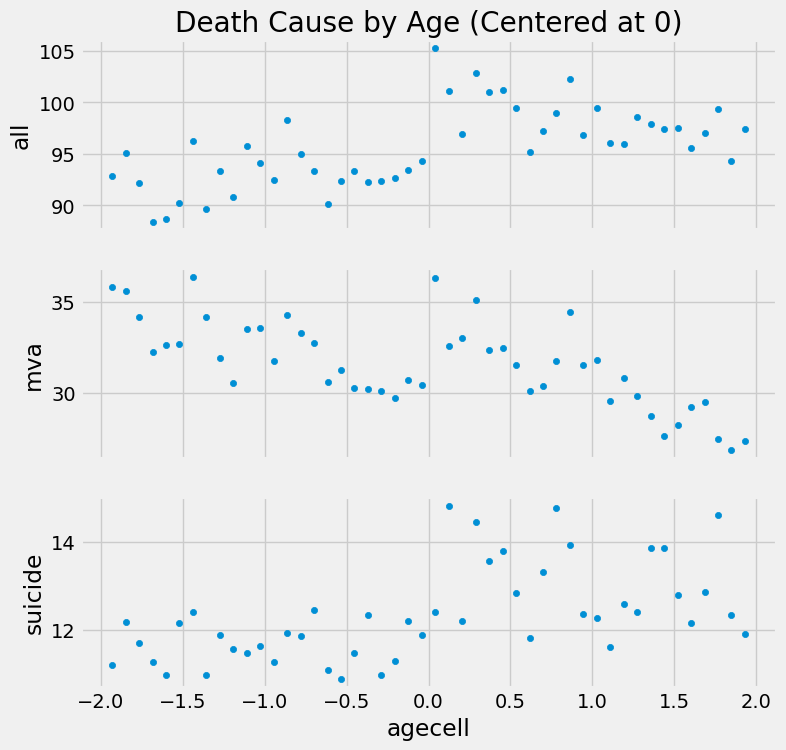

In [13]:
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Death Cause by Age (Centered at 0)")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax);


In [14]:
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))

model = smf.wls("all~agecell*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


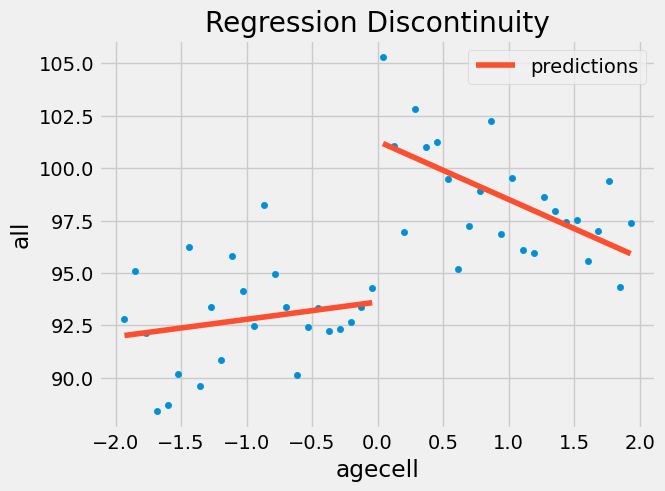

In [15]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity");

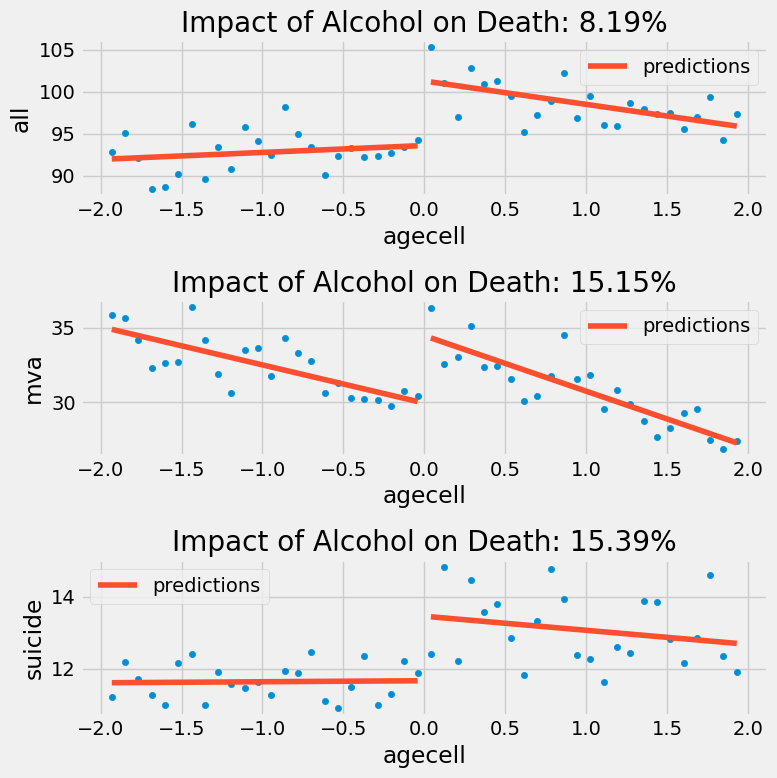

In [16]:
plt.figure(figsize=(8,8))

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

## Bandwidth
We can use the bandwidth to select the range of consideration.

In another sense, the bandwidth is a kernel with weights only on the points within the bandwidth.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
def bandwidth_kernel(x, bandwidth):
    return (np.abs(x - 0) <= bandwidth).astype(float)

def plot_kernel(bandwidth):
    # Generate the x-axis values
    x = np.linspace(-3 * bandwidth, 3 * bandwidth, 500)
    # Compute the Gaussian kernel density
    kernel = bandwidth_kernel(x, bandwidth)
    fig, ax = plt.subplots(2, 1, figsize=(8, 5))
    ax[0].plot(drinking["agecell"], drinking["all"])
    ax[1].plot(x, kernel)
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("Kernel Density")
    ax[0].set_xlim(-3, 3)
    ax[1].set_xlim(-3, 3)
    plt.show()

def on_bandwidth_change(bandwidth):
    # Clear the previous output and re-plot with the updated bandwidth
    plot_kernel(bandwidth)




# Create an interactive slider
interact(on_bandwidth_change, bandwidth=FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='Bandwidth'));


interactive(children=(FloatSlider(value=1.0, description='Bandwidth', max=3.0, min=0.1), Output()), _dom_class…

## Kernel Weighting

We can use smoothing kernel to weight the points within the bandwidth.

Regression Discontinuity relies heavily on the extrapolations properties of linear regression. Since we are looking at the values at the beginning and end of 2 regression lines, we better get those limits right. What can happen is that regression might focus too much on fitting the other data points at the cost of a poor fit at the threshold. If this happens, we might get the wrong measure of the treatment effect.

One way to solve this is to give higher weights for the points that are closer to the threshold. There are many ways to do this, but a popular one is to reweight the samples with the **triangular kernel**

$
K(R, c, h) = \mathcal{1}\{|R-c| \leq h\} * \bigg(1-\frac{|R-c|}{h}\bigg)
$

The first part of this kernel is an indicator function to whether we are close to the threshold. How close? This is determined by a bandwidth parameter $h$. The second part of this kernel is a weighting function. As we move away from the threshold, the weights get smaller and smaller. These weights are divided by the bandwidth. If the bandwidth is large, the weights get smaller at a slower rate. If the bandwidth is small, the weights quickly go to zero. 

To make it easier to understand, here is what the weights look like for this kernel applied to our problem. I've set the bandwidth to be 1 here, meaning we will only consider data from people that are no older than 22 years and no younger than 20 years.

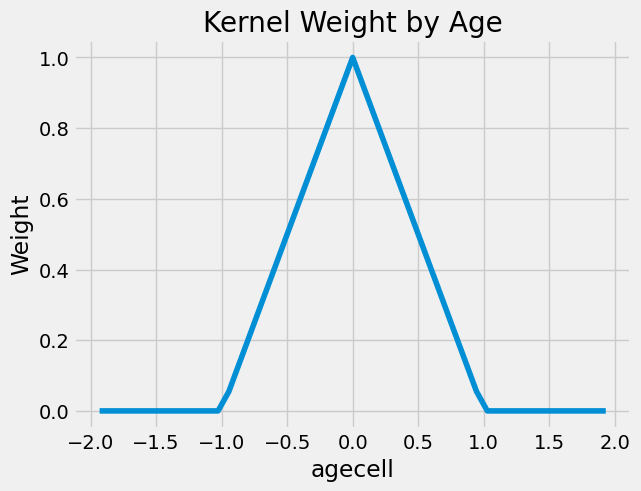

In [18]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)


plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

## References
- https://matheusfacure.github.io/python-causality-handbook/16-Regression-Discontinuity-Design.html

In [19]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


In [20]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


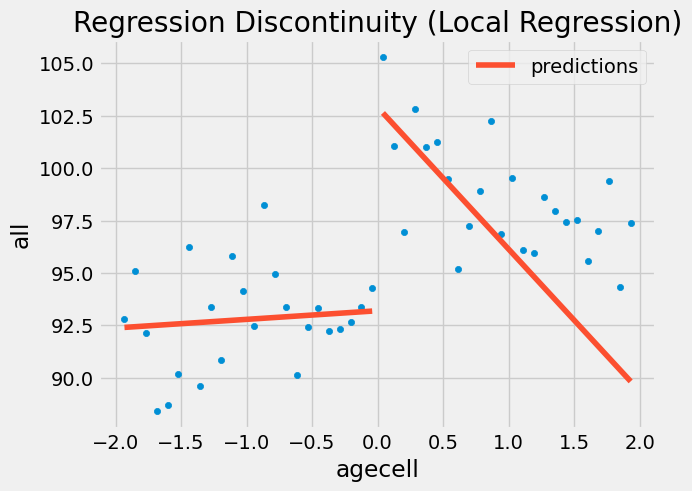

In [21]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)");

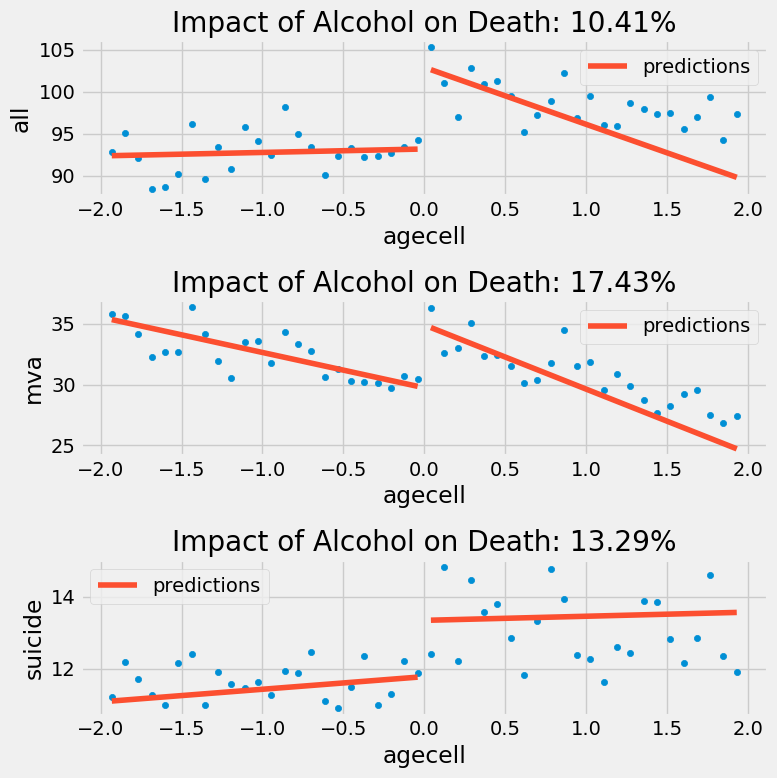

In [22]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df, weights=weights).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

## Fuzzy RDD

\(R=\) SAT score

\(c=\) univeristy cutoff value

\begin{align}
S \neq\left\{\begin{array}{l}
1 \text { if } R \geq c \\
0 \text { if } R<c
\end{array}\right.
\end{align}

$R$ and $c$ dosen't fully determine $S$.

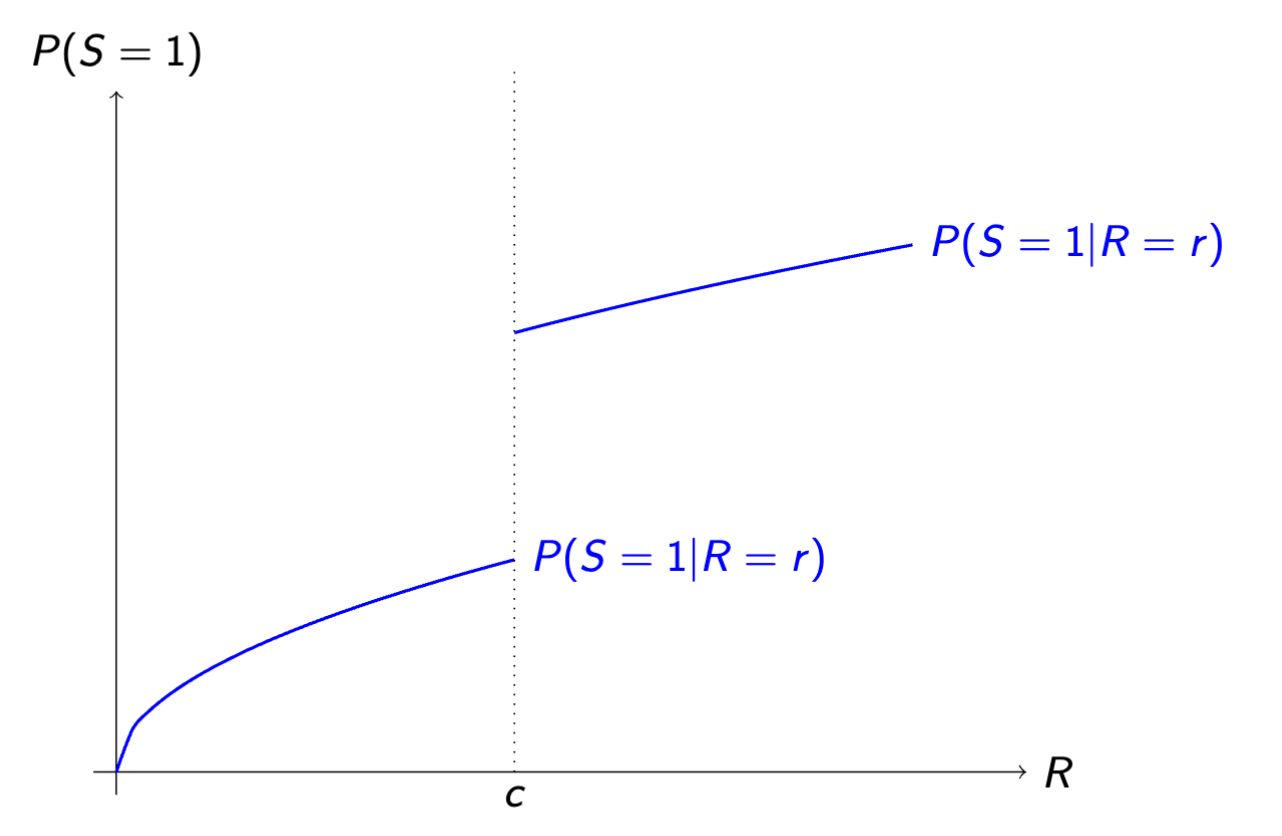

It is not a sharp cutoff, but a probablistic jump.



### Fuzzy RDD as IV

\begin{align}
Z=\left\{\begin{array}{l}
1 \text { if } R \geq c \\
0 \text { if } R<c
\end{array}\right.
\end{align}

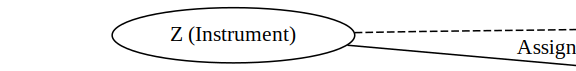

In [23]:
from graphviz import Digraph

# Create a directed graph
fuzzy_rdd_graph = Digraph()
fuzzy_rdd_graph.attr(rankdir='LR', size='8,5')

# Add nodes
fuzzy_rdd_graph.node('Z', 'Z (Instrument)')
fuzzy_rdd_graph.node('T', 'T (Treatment)')
fuzzy_rdd_graph.node('Y', 'Y (Outcome)')
fuzzy_rdd_graph.node('U', 'U (Unobserved Confounders)')

# Add edges
fuzzy_rdd_graph.edge('Z', 'T', label='Assignment Rule')
fuzzy_rdd_graph.edge('T', 'Y', label='Causal Effect')
fuzzy_rdd_graph.edge('U', 'T', label='Confounding Effect')
fuzzy_rdd_graph.edge('U', 'Y', label='Confounding Effect')
fuzzy_rdd_graph.edge('Z', 'Y', style='dashed', label='Exclusion Restriction')

# Render and save the graph
# fuzzy_rdd_graph.render('fuzzy_rdd_causal_graph', view=True)
fuzzy_rdd_graph

**Conditional Exogeneity:**
\begin{align}
Z \perp U, V \mid(R-c), S *(R-c)
\end{align}

**Linearity within Bandwidth:**
\begin{align}
\begin{gathered}
E[Y(S(Z=1, V), U) \mid R=r] \text { and } E[Y(S(Z=0, V), U) \mid R=r] \\
E[S(Z=1, V) \mid R=r] \text { and } E[Y(Z=0, V) \mid R=r]
\end{gathered}
\end{align}

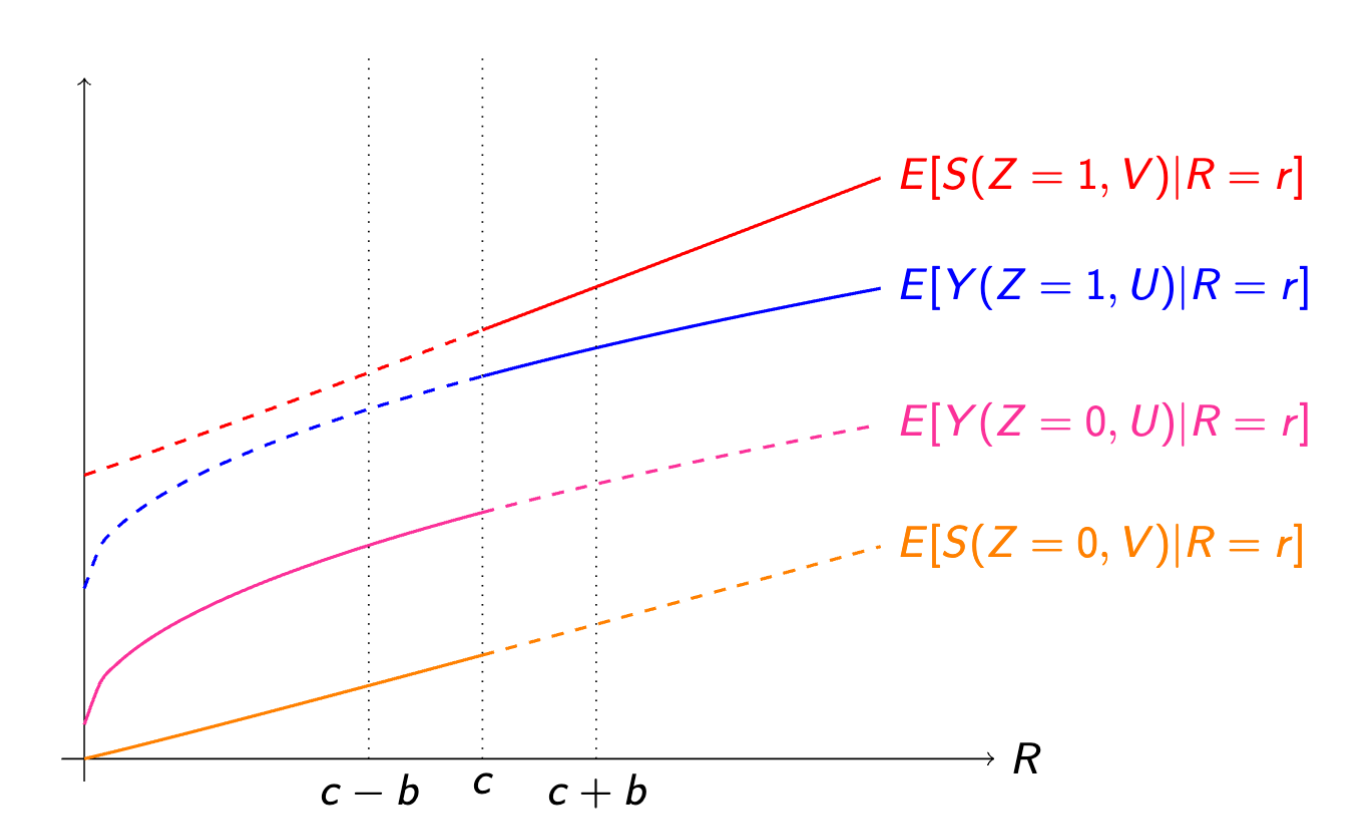

#### Non-weakness


![learning](https://github.com/dapivei/causal-infere/blob/main/images/non_weakness.png?raw=true)

#### Smoothness

![learning](https://github.com/dapivei/causal-infere/blob/main/images/smoothness.png?raw=true)

#### No bunching

![learning](https://github.com/dapivei/causal-infere/blob/main/images/no-bunching.png?raw=true)

In [24]:
# mapping to our case
# - $Z$: SAT score > cutoff
# - $T$: Admission decision
# - $Y$: College GPA
# - $U$: Unobserved factors

## Learning is Learning
Pass the test -> get diploma -> earning

There is a cutoff for the test score, will the diploma be the critical one factor for the earning?

![learning](https://github.com/dapivei/causal-infere/blob/main/images/learning.png?raw=true)